__Background__

Jumpman23 is an on-demand delivery platform connecting “Jumpmen” and customers
purchasing a variety of goods. Jumpman23 will send Jumpmen to merchants to purchase and
pickup any items requested by the customer. Whenever possible, Jumpman23 will order the
requested items ahead to save the Jumpmen time. Each time a Jumpman23 delivery is
completed, a record is saved to the Jumpman23 database that contains information about that
delivery. Jumpman23 is growing fast and has just launched in its newest market -- New York City.

__Challenge__

The CEO of Jumpman23 has just asked you how are things going in New York? The CEO is
considering pouring more resources into NYC and wants you to come up with a plan to grow the
market by 20% in two months.
They have also heard of data integrity issues in the data from NYC. Please think through the
CEO’s ask and present to both the CEO and the CTO, in any format you choose, an analysis of
the market. In addition, dive into the reports on data integrity issues and if they indeed exist,
outline where they may be and how they may impact the analysis. The CEO is a visual learner,
the CTO loves to see code and technical work, and both are obsessed with maps.

__I'd like to include my suggestions to grow the market here, in the beginning, to make it more easy to locate.__

__Plan to grow the market by 20%__

After analyzing the data first thing I noticed was how the activity is concentrated in particularly Manhattan and almost no pickup or delivery in other boroughs of NYC other than a small part of Brooklyn. To be able to better understand the demographics off the top customers, we can exract the zipcodes from given dropoff lattitudes and longitudes and understand key stats of those areas like median household income, families vs singles, households_with_kids to be able to understand best zipcodes within NYC that are currently untapped. After determining target zip codes, shifting existing resources from Manhattan by having Jumpmans deliver multiple order at the same time after bundling deliveries originating from and destinated to nearby locations. Recuriting more Jumpman that are available close to new areas should definitely help with keeping up with demand more efficiently and on time. This would ultimately increase return customers and will achieve steady volume.

Let's start with importing necessary libraries. To be able to use gmaps, a Google Maps API key needs to be assigned to the API_KEY variable. Maps Javascript API and Directions Matrix API needs to be enabled for the same API key.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import json
import requests
from IPython.display import display
import ipywidgets as widgets
from uszipcode import SearchEngine, SimpleZipcode, Zipcode
import gmaps
API_KEY = 'AI..'
gmaps.configure(api_key=API_KEY)
new_york_coordinates = (40.75, -74.00)

Next step would be importing data from provided csv file and converting it into a Pandas dataframe. Timestamp fields needs to be parsed to be able to do calculations. Before moving into analysis, calculating some fields like delivery time or hour part of each delivery start time should make things easier ahead.

In [2]:
df = pd.read_csv('analyze_me.csv', converters = {'how_long_it_took_to_order':pd.to_timedelta},
                                    parse_dates= ['when_the_delivery_started',
                                                 'when_the_Jumpman_arrived_at_pickup',
                                                 'when_the_Jumpman_left_pickup',
                                                 'when_the_Jumpman_arrived_at_dropoff'], 
                                     infer_datetime_format = True)
df['how_long_it_took_to_order_in_minutes'] = (df['how_long_it_took_to_order'].astype('timedelta64[s]')/60).round(2)
df['time_spent_at_merchant'] = df['when_the_Jumpman_left_pickup'] - df['when_the_Jumpman_arrived_at_pickup']
df['time_spent_at_merchant_minutes'] = (df['time_spent_at_merchant'].astype('timedelta64[s]')/60).round(2)
df['delivery_time'] = df['when_the_Jumpman_arrived_at_dropoff'] - df['when_the_delivery_started']
df['delivery_time_minutes'] = (df['delivery_time'].astype('timedelta64[s]')/60).round(2)
df['delivery_start_hour'] = df['when_the_delivery_started'].dt.hour

In [3]:
def route_generator(pickup_lat, pickup_lon,dropoff_lat,dropoff_lon, mode):
    new_array = []
    url ='https://maps.googleapis.com/maps/api/distancematrix/json?units=imperial'
    origin = str(pickup_lat)+','+str(pickup_lon)
    destination = str(dropoff_lat)+','+str(dropoff_lon)
    if mode == 'bicycle' or mode=='scooter':
        mode='bicycling'
    elif mode== 'car' or mode=='motorcycle' or mode=='truck' or mode=='van':
        mode='driving'
    elif mode=='walker':
        mode='walking'
    r = requests.get(url + '&origins=' + origin +
                       '&destinations=' + destination +
                       '&mode=' + mode +
                       '&key=' + API_KEY)
    response = r.json()
#     print(response)

    pickup_zipcode = response['origin_addresses'][0].split(',')[-2][3:]
    dropoff_zipcode = response['destination_addresses'][0].split(',')[-2][3:]
    drive_time = response['rows'][0]['elements'][0]['duration']['value']/60
    distance = response['rows'][0]['elements'][0]['distance']['value']
    new_array = [pickup_zipcode,dropoff_zipcode,drive_time,distance]
    return new_array

# print(route_generator(40.744607,-73.990742,40.752073,-73.985370,'walker'))

df_adjusted = df

for index,row in df_adjusted.iterrows():
    stg = route_generator(row['pickup_lat'],row['pickup_lon'],row['dropoff_lat'],row['dropoff_lon'],row['vehicle_type'])
    df_adjusted.loc[index,'pickup_zipcode'] = stg[0]
    df_adjusted.loc[index,'dropoff_zipcode'] = stg[1]
    df_adjusted.loc[index,'maps_api_route_time'] = stg[2]
    df_adjusted.loc[index,'maps_api_route_distance'] = stg[3]
df_adjusted['maps_api_route_time'] = df_adjusted['maps_api_route_time'].round(2)
df_adjusted['maps_api_route_distance'] = (df_adjusted['maps_api_route_distance']/1609).round(2) # meters to miles conversion    

After iterating over each row and running route_generator function to save calculated fields for later use in case there is a need to restart the notebook. New csv file(df_adjusted.csv) is saved in the same directory with this notebook file.

In [4]:
df_adjusted.to_csv (r'df_adjusted.csv', index = False, header=True)

Previous code blocks are commented out to prevent overwriting existing files.

Let's look at the first five rows of df_adjusted dataframe to have an understanding of how each column looks like.


In [5]:
df_adjusted.head()

,delivery_id,customer_id,jumpman_id,vehicle_type,pickup_place,place_category,item_name,item_quantity,item_category_name,how_long_it_took_to_order,...,how_long_it_took_to_order_in_minutes,time_spent_at_merchant,time_spent_at_merchant_minutes,delivery_time,delivery_time_minutes,delivery_start_hour,pickup_zipcode,dropoff_zipcode,maps_api_route_time,maps_api_route_distance
0,1457973,327168,162381,van,Melt Shop,American,Lemonade,1.0,Beverages,0 days 00:19:58.582052,...,19.97,NaT,NaN,0 days 01:00:06.414164,60.10,13,10010,10018,6.02,1.07
1,1377056,64452,104533,bicycle,Prince Street Pizza,Pizza,Neapolitan Rice Balls,3.0,Munchables,0 days 00:25:09.107093,...,25.15,0 days 00:22:20.970322,22.33,0 days 01:00:24.293963,60.40,21,10012,10002,5.88,0.76
2,1476547,83095,132725,bicycle,Bareburger,Burger,Bare Sodas,1.0,Drinks,0 days 00:06:44.541717,...,6.73,0 days 00:21:51.191405,21.85,0 days 00:24:47.980568,24.78,21,10012,10012,1.28,0.27
3,1485494,271149,157175,bicycle,Juice Press,Juice Bar,OMG! My Favorite Juice!,1.0,Cold Pressed Juices,NaT,...,NaN,0 days 00:12:20.136239,12.33,0 days 00:38:26.558167,38.43,10,10014,10001,8.60,1.26
4,1327707,122609,118095,bicycle,Blue Ribbon Sushi,Japanese,Spicy Tuna & Tempura Flakes,2.0,Maki (Special Rolls),0 days 00:03:45.035418,...,3.75,0 days 00:10:36.698071,10.60,0 days 00:41:08.700090,41.13,0,10012,10280,12.62,2.19


Then we can move onto generating descriptive statistics for our dataset if applicable.

In [6]:
df_adjusted.describe()

,delivery_id,customer_id,jumpman_id,item_quantity,how_long_it_took_to_order,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon,how_long_it_took_to_order_in_minutes,time_spent_at_merchant,time_spent_at_merchant_minutes,delivery_time,delivery_time_minutes,delivery_start_hour,maps_api_route_time,maps_api_route_distance
count,5.983000e+03,5983.000000,5983.000000,4753.000000,3038,5983.000000,5983.000000,5983.000000,5983.000000,3038.000000,5433,5433.000000,5983,5983.000000,5983.000000,5983.000000,5983.000000
mean,1.379495e+06,176472.595521,102661.602541,1.248264,0 days 00:07:49.173169902,40.741425,-73.987101,40.744216,-73.985765,7.811004,0 days 00:18:54.965448500,18.907828,0 days 00:46:04.870654038,46.072761,16.480862,10.393667,1.597018
std,6.459397e+04,116414.487842,48607.211795,0.785904,0 days 00:05:39.647884785,0.022833,0.014896,0.025251,0.018060,5.660782,0 days 00:12:26.868365377,12.447894,0 days 00:20:13.598486661,20.226546,4.380200,8.398950,1.327850
min,1.271706e+06,242.000000,3296.000000,1.000000,0 days 00:01:22.997519,40.665611,-74.015837,40.649356,-74.017679,1.370000,0 days 00:00:00.112647,0.000000,0 days 00:03:02.830850,3.030000,0.000000,0.030000,0.010000
25%,1.322792e+06,77817.000000,60761.000000,1.000000,0 days 00:04:26.916916,40.724340,-73.996630,40.725307,-74.000297,4.435000,0 days 00:10:49.009145,10.820000,0 days 00:32:40.034945,32.670000,13.000000,5.210000,0.730000
50%,1.375689e+06,131093.000000,113364.000000,1.000000,0 days 00:06:17.250409,40.735677,-73.988682,40.740424,-73.989280,6.280000,0 days 00:15:48.615535,15.800000,0 days 00:42:40.486114,42.670000,18.000000,8.430000,1.240000
75%,1.436371e+06,293381.000000,143807.000000,1.000000,0 days 00:09:12.073802500,40.758726,-73.980739,40.763885,-73.974696,9.192500,0 days 00:23:50.280362,23.830000,0 days 00:55:07.618052,55.120000,20.000000,13.270000,2.020000
max,1.491424e+06,405547.000000,181543.000000,16.000000,0 days 01:13:13.266118,40.818082,-73.920980,40.848324,-73.924124,73.220000,0 days 04:27:57.242617,267.950000,0 days 05:40:18.528600,340.300000,23.000000,131.820000,11.190000


It should be one of the first things to check if there are any missing data in the given set. We were already able to catch some rows with missing values after displaying first five rows but let's look at how many missing data in each column.

In [7]:
df_adjusted.isnull().sum()

delivery_id                                0
customer_id                                0
jumpman_id                                 0
vehicle_type                               0
pickup_place                               0
place_category                           883
item_name                               1230
item_quantity                           1230
item_category_name                      1230
how_long_it_took_to_order               2945
pickup_lat                                 0
pickup_lon                                 0
dropoff_lat                                0
dropoff_lon                                0
when_the_delivery_started                  0
when_the_Jumpman_arrived_at_pickup       550
when_the_Jumpman_left_pickup             550
when_the_Jumpman_arrived_at_dropoff        0
how_long_it_took_to_order_in_minutes    2945
time_spent_at_merchant                   550
time_spent_at_merchant_minutes           550
delivery_time                              0
delivery_t

In order to have an understanding of things like how many customers used the platform or how many jumpman completed deliver during given time period, we can check number of unique values for each column.

In [8]:
df_adjusted.nunique()

delivery_id                             5214
customer_id                             3192
jumpman_id                               578
vehicle_type                               7
pickup_place                             898
place_category                            57
item_name                               2277
item_quantity                             11
item_category_name                       767
how_long_it_took_to_order               2579
pickup_lat                              1210
pickup_lon                              1179
dropoff_lat                             2841
dropoff_lon                             2839
when_the_delivery_started               5214
when_the_Jumpman_arrived_at_pickup      4719
when_the_Jumpman_left_pickup            4717
when_the_Jumpman_arrived_at_dropoff     5214
how_long_it_took_to_order_in_minutes     846
time_spent_at_merchant                  4719
time_spent_at_merchant_minutes          1366
delivery_time                           5214
delivery_t

We already have latitudes and longitudes for pickup and dropoff points and by using gmaps library, we can create a heatmap showing frequency of pickups or dropoffs per hour. Hour can be changed using the sliding widget on both maps.

In [9]:
class Vertical(object):    
    class PickupExplorer(object):
        """
        Jupyter widget for exploring the Jumpman23 dataset for NYC.

        The user uses the slider to choose an hour. This renders
        heatmaps of pickups and dropoffs separately.
        """
        def __init__(self, df_adjusted):
            self._df_adjusted = df_adjusted
            self._heatmap = None
            self._slider = None
            initial_hour = min(self._df_adjusted['when_the_delivery_started'].dt.hour)
            title_widget = widgets.HTML(
                '<h3>Jumpman23 Hourly Pickups</h3>'
            )

            map_figure = self._render_map(initial_hour)
            controls = self._render_controls(initial_hour)
            self._container = widgets.VBox([title_widget, controls, map_figure])

        def render(self):
            display(self._container)

        def _on_hour_change(self, change):
            hour = self._slider.value
            self._heatmap.locations = self._locations_for_hour(hour)
            self._total_box.value = self._total_actions_text_for_hour(hour)
            return self._container

        def _render_map(self, initial_hour):
            fig = gmaps.figure(map_type='ROADMAP',center=new_york_coordinates, zoom_level=11)
            self._heatmap = gmaps.heatmap_layer(
                self._locations_for_hour(initial_hour),
                max_intensity=1,
                point_radius=7
            )
            fig.add_layer(self._heatmap)
            return fig

        def _render_controls(self, initial_hour):
            style = {'description_width': 'initial'}
            self._slider = widgets.SelectionSlider(
                options=np.sort(df_adjusted['when_the_delivery_started'].dt.hour.unique()),
                value=np.sort(df_adjusted['when_the_delivery_started'].dt.hour.unique())[0],
                description='Hour of the day', style=style,
                disabled=False,
                continuous_update=True,
                orientation='horizontal',
                readout=True
            )
            self._total_box = widgets.Label(
                value=self._total_actions_text_for_hour(initial_hour)
            )
            self._slider.observe(self._on_hour_change, names='value')
            controls = widgets.HBox(
                [self._slider, self._total_box],
                layout={'justify_content': 'space-between'}
            )
            return controls  

        def _locations_for_hour(self, hour):
                return self._df_adjusted[self._df_adjusted['when_the_delivery_started'].dt.hour == hour][['pickup_lat', 'pickup_lon']]
        def _total_actions_for_hour(self, hour):
            return int(self._df_adjusted[self._df_adjusted['when_the_delivery_started'].dt.hour == hour]['when_the_delivery_started'].dt.hour.count())
        def _total_actions_text_for_hour(self, hour):
            return '{} pickups by Jumpmen'.format(self._total_actions_for_hour(hour))
    class DropoffExplorer(object):
        """
        Jupyter widget for exploring the Jumpman23 dataset for NYC.

        The user uses the slider to choose an hour. This renders
        a heatmap of pickups or dropoffs.
        """
        def __init__(self, df_adjusted):
            self._df_adjusted = df_adjusted
            self._heatmap = None
            self._slider = None
            initial_hour = min(self._df_adjusted['when_the_Jumpman_arrived_at_dropoff'].dt.hour)
            title_widget = widgets.HTML(
                '<h3>Jumpman23 Hourly Dropoffs</h3>'
            )

            map_figure = self._render_map(initial_hour)
            controls = self._render_controls(initial_hour)
            self._container = widgets.VBox([title_widget, controls, map_figure])

        def render(self):
            display(self._container)

        def _on_hour_change(self, change):
            hour = self._slider.value
            self._heatmap.locations = self._locations_for_hour(hour)
            self._total_box.value = self._total_actions_text_for_hour(hour)
            return self._container

        def _render_map(self, initial_hour):
            fig = gmaps.figure(map_type='ROADMAP',center=new_york_coordinates, zoom_level=11)
            self._heatmap = gmaps.heatmap_layer(
                self._locations_for_hour(initial_hour),
                max_intensity=1,
                point_radius=7
            )
            fig.add_layer(self._heatmap)
            return fig

        def _render_controls(self, initial_hour):
            style = {'description_width': 'initial'}
            self._slider = widgets.SelectionSlider(
                options=np.sort(df_adjusted['when_the_Jumpman_arrived_at_dropoff'].dt.hour.unique()),
                value=np.sort(df_adjusted['when_the_Jumpman_arrived_at_dropoff'].dt.hour.unique())[0],
                description='Hour of the day',style=style,
                disabled=False,
                continuous_update=True,
                orientation='horizontal',
                readout=True
            )
            self._total_box = widgets.Label(
                value=self._total_actions_text_for_hour(initial_hour)
            )
            self._slider.observe(self._on_hour_change, names='value')
            controls = widgets.HBox(
                [self._slider, self._total_box],
                layout={'justify_content': 'space-between'}
            )
            return controls  

        def _locations_for_hour(self, hour):
            return self._df_adjusted[self._df_adjusted['when_the_Jumpman_arrived_at_dropoff'].dt.hour == hour][['dropoff_lat', 'dropoff_lon']]

        def _total_actions_for_hour(self, hour):
            return int(self._df_adjusted[self._df_adjusted['when_the_Jumpman_arrived_at_dropoff'].dt.hour == hour]['when_the_Jumpman_arrived_at_dropoff'].dt.hour.count())

        def _total_actions_text_for_hour(self, hour):
            return '{} dropoffs at customers'.format(self._total_actions_for_hour(hour))
        

    PickupExplorer(df_adjusted).render()

    DropoffExplorer(df_adjusted).render()

![GifUrl](https://media.giphy.com/media/3pJ8r9x5stkgA5zxnt/giphy.gif "Pickup and Dropoff Heatmaps")

We can produce the same map for the days of the week.

In [10]:
class VerticalWeek(object):    
    class PickupExplorer_Week(object):
        """
        Jupyter widget for exploring the Jumpman23 dataset for NYC.

        The user uses the slider to choose an hour. This renders
        heatmaps of pickups and dropoffs separately.
        """
        def __init__(self, df_adjusted):
            self._df_adjusted = df_adjusted
            self._heatmap = None
            self._slider = None
            initial_day = 0
            title_widget = widgets.HTML(
                '<h3>Jumpman23 Daily Pickups</h3>'
            )

            map_figure = self._render_map(initial_day)
            controls = self._render_controls(initial_day)
            self._container = widgets.VBox([title_widget, controls, map_figure])

        def render(self):
            display(self._container)

        def _on_day_change(self, change):
            day = self._slider.value
            self._heatmap.locations = self._locations_for_day(day)
            self._total_box.value = self._total_actions_text_for_day(day)
            return self._container

        def _render_map(self, initial_day):
            fig = gmaps.figure(map_type='ROADMAP',center=new_york_coordinates, zoom_level=11)
            self._heatmap = gmaps.heatmap_layer(
                self._locations_for_day(initial_day),
                max_intensity=1,
                point_radius=7
            )
            fig.add_layer(self._heatmap)
            return fig

        def _render_controls(self, initial_day):
            style = {'description_width': 'initial'}
            self._slider = widgets.SelectionSlider(
                options=np.sort(df_adjusted['when_the_Jumpman_arrived_at_dropoff'].dt.dayofweek.unique()),
                value=np.sort(df_adjusted['when_the_Jumpman_arrived_at_dropoff'].dt.dayofweek.unique())[0],
                description='Day of the week', style=style,
                disabled=False,
                continuous_update=True,
                orientation='horizontal',
                readout=True
            )
            self._total_box = widgets.Label(
                value=self._total_actions_text_for_day(initial_day)
            )
            self._slider.observe(self._on_day_change, names='value')
            controls = widgets.HBox(
                [self._slider, self._total_box],
                layout={'justify_content': 'space-between'}
            )
            return controls  

        def _locations_for_day(self, day):
                return self._df_adjusted[self._df_adjusted['when_the_delivery_started'].dt.dayofweek == day][['pickup_lat', 'pickup_lon']]
        def _total_actions_for_day(self, day):
            return int(self._df_adjusted[self._df_adjusted['when_the_delivery_started'].dt.dayofweek == day]['when_the_delivery_started'].dt.dayofweek.count())
        def _total_actions_text_for_day(self, day):
            return '{} pickups by Jumpmen'.format(self._total_actions_for_day(day))
    class DropoffExplorer_Week(object):
        """
        Jupyter widget for exploring the Jumpman23 dataset for NYC.

        The user uses the slider to choose an hour. This renders
        heatmaps of pickups and dropoffs separately.
        """
        def __init__(self, df_adjusted):
            self._df_adjusted = df_adjusted
            self._heatmap = None
            self._slider = None
            initial_day = 0
            title_widget = widgets.HTML(
                '<h3>Jumpman23 Daily Dropoffs</h3>'
            )

            map_figure = self._render_map(initial_day)
            controls = self._render_controls(initial_day)
            self._container = widgets.VBox([title_widget, controls, map_figure])

        def render(self):
            display(self._container)

        def _on_day_change(self, change):
            day = self._slider.value
            self._heatmap.locations = self._locations_for_day(day)
            self._total_box.value = self._total_actions_text_for_day(day)
            return self._container

        def _render_map(self, initial_day):
            fig = gmaps.figure(map_type='ROADMAP',center=new_york_coordinates, zoom_level=11)
            self._heatmap = gmaps.heatmap_layer(
                self._locations_for_day(initial_day),
                max_intensity=1,
                point_radius=7
            )
            fig.add_layer(self._heatmap)
            return fig

        def _render_controls(self, initial_day):
            style = {'description_width': 'initial'}
            self._slider = widgets.SelectionSlider(
                options=np.sort(df_adjusted['when_the_Jumpman_arrived_at_dropoff'].dt.dayofweek.unique()),
                value=np.sort(df_adjusted['when_the_Jumpman_arrived_at_dropoff'].dt.dayofweek.unique())[0],
                description='Day of the week', style=style,
                disabled=False,
                continuous_update=True,
                orientation='horizontal',
                readout=True
            )
            self._total_box = widgets.Label(
                value=self._total_actions_text_for_day(initial_day)
            )
            self._slider.observe(self._on_day_change, names='value')
            controls = widgets.HBox(
                [self._slider, self._total_box],
                layout={'justify_content': 'space-between'}
            )
            return controls  

        def _locations_for_day(self, day):
                return self._df_adjusted[self._df_adjusted['when_the_Jumpman_arrived_at_dropoff'].dt.dayofweek == day][['pickup_lat', 'pickup_lon']]
        def _total_actions_for_day(self, day):
            return int(self._df_adjusted[self._df_adjusted['when_the_Jumpman_arrived_at_dropoff'].dt.dayofweek == day]['when_the_Jumpman_arrived_at_dropoff'].dt.dayofweek.count())
        def _total_actions_text_for_day(self, day):
            return '{} dropoffs at customers'.format(self._total_actions_for_day(day))

    PickupExplorer_Week(df_adjusted).render()

    DropoffExplorer_Week(df_adjusted).render()

Maps shows us that throughout the day, majority of activity is happening across Manhattan and ocassionally in Brooklyn. Creating a histogram plot of the same except location and adding a breakdown based on mode of transportation should provide more insights.

Text(0.5, 1.0, 'Breakdown by hour and vehicle type')

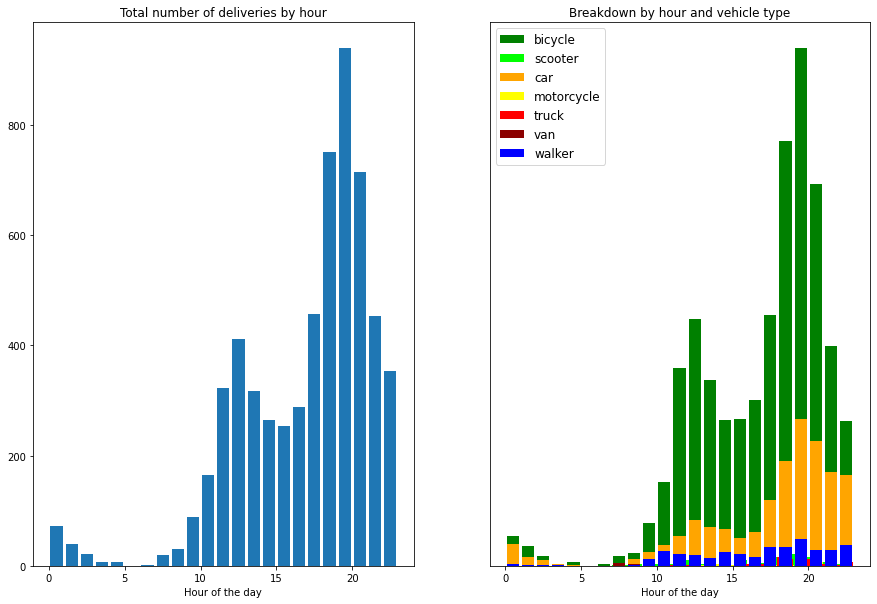

In [11]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,10))

ax1.hist(df_adjusted['delivery_start_hour'],bins=df_adjusted['delivery_start_hour'].max() - df_adjusted['delivery_start_hour'].min(), rwidth=0.8)
ax1.set_xlabel('Hour of the day')
ax1.set_title('Total number of deliveries by hour')

x1 = df_adjusted.loc[df_adjusted.vehicle_type=='bicycle', 'delivery_start_hour']
x2 = df_adjusted.loc[df_adjusted.vehicle_type=='scooter', 'delivery_start_hour']
x3 = df_adjusted.loc[df_adjusted.vehicle_type=='car', 'delivery_start_hour']
x4 = df_adjusted.loc[df_adjusted.vehicle_type=='motorcycle', 'delivery_start_hour']
x5 = df_adjusted.loc[df_adjusted.vehicle_type=='truck', 'delivery_start_hour']
x6 = df_adjusted.loc[df_adjusted.vehicle_type=='van', 'delivery_start_hour']
x7 = df_adjusted.loc[df_adjusted.vehicle_type=='walker', 'delivery_start_hour']
ax2.hist(x1,bins=df_adjusted['delivery_start_hour'].max()-df_adjusted['delivery_start_hour'].min(), rwidth=0.8,stacked=True,color='green', label='bicycle')
ax2.hist(x2,bins=df_adjusted['delivery_start_hour'].max()-df_adjusted['delivery_start_hour'].min(), rwidth=0.8,stacked=True,color='lime', label='scooter')
ax2.hist(x3,bins=df_adjusted['delivery_start_hour'].max()-df_adjusted['delivery_start_hour'].min(), rwidth=0.8,stacked=True,color='orange', label='car')
ax2.hist(x4,bins=df_adjusted['delivery_start_hour'].max()-df_adjusted['delivery_start_hour'].min(), rwidth=0.8,stacked=True,color='yellow', label='motorcycle')
ax2.hist(x5,bins=df_adjusted['delivery_start_hour'].max()-df_adjusted['delivery_start_hour'].min(), rwidth=0.8,stacked=True,color='red', label='truck')
ax2.hist(x6,bins=df_adjusted['delivery_start_hour'].max()-df_adjusted['delivery_start_hour'].min(), rwidth=0.8,stacked=True,color='darkred', label='van')
ax2.hist(x7,bins=df_adjusted['delivery_start_hour'].max()-df_adjusted['delivery_start_hour'].min(), rwidth=0.8,stacked=True,color='blue', label='walker')
ax2.axes.get_yaxis().set_visible(False)
ax2.legend(prop={'size': 12})
ax2.set_xlabel('Hour of the day')
ax2.set_title('Breakdown by hour and vehicle type')

Based on the data, we are able to identify that demand starts to increase in the afternoon and it reaches its peak at 7pm.

The chart above reveals that bicycle is the most preferred option among other alternatives and it is trailed by driving cars and walking. We can calculate the mean and median duration for deliveries grouped by mode of transporation and compare it with the output of Directios Matrix API(doesn't take traffic into consideration).

In [12]:
df_adjusted.groupby(['vehicle_type']).agg({'delivery_time_minutes': ['mean','median'],'maps_api_route_time': ['mean','median']})

delivery_time_minutes        maps_api_route_time        
                              mean median                mean  median
vehicle_type                                                         
bicycle                  44.009406  41.26            9.296659   7.850
car                      52.022527  47.57           10.455103   9.300
motorcycle               47.076667  44.00            9.970952   9.120
scooter                  47.369867  44.68           10.254800   9.080
truck                    65.710417  62.80           14.119792  13.565
van                      50.423947  47.46            9.109474   8.075
walker                   46.795949  45.36           27.006825  20.250

Although calculated time between pickup and dropoff points using the API doesn't reflect the actual traffic, we can still utilize the data because majority of deliveries made using a bicycle. There is a significant variance between actual duration of delivery and the target. It makes sense to have a major difference on deliveries made with motor vehicles but walking and cyclying shouldn't differ at the same rate. One reason for this could be is difficulty accessing the perimeter at dropoff point or unable to find a parking spot etc.

In [13]:
pickup_places_with_null_categories = df_adjusted[df_adjusted['place_category'].isnull()]["pickup_place"].value_counts(normalize=True)
print('{} pickup places are missing a category name'.format(len(pickup_places_with_null_categories)))

419 pickup places are missing a category name


Missing values for place_category column are the easiest ones to fix since the data itself is static for the given time period and it is possible to backfill the data reliably.

It should be a good idea to order popular items from popular places to decrease wait times at these hot spots.

In [20]:
df_adjusted['pickup_place'].value_counts().head(25)

Shake Shack                              311
Momofuku Milk Bar                        186
The Meatball Shop                        184
Blue Ribbon Sushi                        151
sweetgreen                               149
Blue Ribbon Fried Chicken                133
Whole Foods Market                       119
Parm                                     102
RedFarm Broadway                          93
Mighty Quinn's BBQ                        90
Chipotle Mexican Grill $1.99 Delivery     80
Momofuku Noodle Bar                       74
Hu Kitchen                                68
Trader Joe's                              68
TAO                                       67
Han Dynasty                               66
Sushi of Gari 46                          64
Duane Reade                               64
McDonald's                                62
RedFarm Hudson                            60
Doughnut Plant Chelsea                    60
La Esquina Taqueria                       58
Nobu Next 

In [22]:
total_wait_time_per_pickup_place = df_adjusted.groupby(['pickup_place'])['time_spent_at_merchant_minutes'].mean().dropna().sort_values(ascending=False)
total_wait_time_per_pickup_place.head(20)

pickup_place
Denny's                          51.730000
Trader Joe's                     51.234426
Friend of a Farmer               51.000000
Jack the Horse Tavern            50.750000
Lantern Thai Kitchen             50.300000
Nicola's Restaurant              48.670000
Gemma at Bowery Hotel            46.330000
Hester Street Fair               45.900000
Fette Sau                        45.820000
Amma                             44.947500
Socarrat Paella Bar              44.666667
Souen                            44.520000
An Choi                          44.050000
Chelsea Market                   43.460000
Fairway Market                   43.330000
Sugar Factory                    42.780000
Whole Foods Market               42.718660
Michael's                        42.350000
Absolute Bagel                   39.930000
Seasonal Restaurant & Weinbar    39.820000
Name: time_spent_at_merchant_minutes, dtype: float64

(array([ 79., 288., 363., 431., 391., 312., 270., 163., 136., 119.,  85.,
         50.,  45.,  56.,  32.,  35.,  27.,  19.,  23.,  17.,  16.,  11.,
         10.,  10.,   6.,  11.,   3.,   1.,   5.,   4.,   2.,   4.,   0.,
          1.,   2.,   1.,   2.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          1.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   2.]),
 array([ 1.36666667,  2.36458333,  3.3625    ,  4.36041667,  5.35833333,
         6.35625   ,  7.35416667,  8.35208333,  9.35      , 10.34791667,
        11.34583333, 12.34375   , 13.34166667, 14.33958333, 15.3375    ,
        16.33541667, 17.33333333, 18.33125   , 19.32916667, 20.32708333,
        21.325     , 22.32291667, 23.32083333, 24.31875   , 25.31666667,
        26.31458333, 27.3125    , 28.31041667, 29.30833333, 30.30625   ,
        31.30416667, 32.30208333, 33.3       , 34.29791667, 35.29583333,

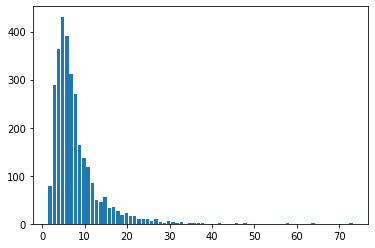

In [23]:
plt.hist(df_adjusted[pd.notnull(df_adjusted['how_long_it_took_to_order'].astype('timedelta64[s]'))]['how_long_it_took_to_order'].astype('timedelta64[s]')/60,bins=72, rwidth=.8)

It looks like amount of time spent by customers are particularly high for limited number of deliveries. It is not widespread but needs more attention to it. If it is taking too much time for the users to complete ordering might indicate that there could be a UX issue making it difficult to proceed.

In [24]:
df_adjusted[df_adjusted['how_long_it_took_to_order'].isnull()].groupby(['delivery_id'])['customer_id'].value_counts().head(10)

delivery_id  customer_id
1271706      66556          1
1271751      104131         1
1271867      121706         1
1272303      107621         1
1272363      315298         1
1272382      118665         1
1272451      103329         1
1272468      183564         1
1272470      270525         1
1272507      91981          1
Name: customer_id, dtype: int64

Being able to track how long it takes customers to order should help better understanding if the UX is designed well or there are room for improvement. If more data is available about the session like device, browser information, that would enable to us have better understanding of the cause of this error.

It is important to note that some of the delivery ids repeat itself in the given data set. Although most of the time it makes sense because of the way records are kept but keeping those records in a nested format could be a better idea. There are instances where same items within the same order repeat itself over mutiple rows. It's difficult determine if they are simply duplicate entries or records are not kept properly.

In [26]:
df_adjusted.groupby(['delivery_id'])['item_quantity'].sum().value_counts()

1.0     2798
0.0     1230
2.0      803
3.0      209
4.0      100
5.0       32
6.0       18
7.0        8
8.0        6
9.0        4
12.0       1
30.0       1
11.0       1
15.0       1
10.0       1
16.0       1
Name: item_quantity, dtype: int64

In [27]:
if df_adjusted[df_adjusted['item_name'].isnull()].equals(df_adjusted[df_adjusted['item_quantity'].isnull()]) and df_adjusted[df_adjusted['item_name'].isnull()].equals(df_adjusted[df_adjusted['item_category_name'].isnull()]):
        print('item_name, item_quantity, item_category_name columns are missing at the same time in the given dataset and this happens {} times for {} unique deliveries at {} unique pickup_places '.format(df_adjusted['item_name'].isnull().sum(),df_adjusted[df_adjusted['item_name'].isnull()]['delivery_id'].nunique(),df_adjusted[df_adjusted['item_name'].isnull()]['pickup_place'].nunique()))

item_name, item_quantity, item_category_name columns are missing at the same time in the given dataset and this happens 1230 times for 1230 unique deliveries at 592 unique pickup_places 


Having missing info for columns describing the items ordered might be the original design rather than a data integrity issue. If the platform allows customers to order from places that are not listed but available for custom orders.

In [28]:
pick_up_places_with_missing_items = df_adjusted[df_adjusted['item_name'].isnull()]['pickup_place'].nunique()
print('{} unique pickup place are missing item names, quantity.'.format(pick_up_places_with_missing_items))

592 unique pickup place are missing item names, quantity.


This could result in increased wait times at the pickup place because the order is not prepared ahead and Jumpmans would need to order or browse through aisles to find items ordered. Targeting top places(in high demand) matching this category and having them listed on the platform should improve overall wait times.

In [29]:
if df_adjusted[df_adjusted['when_the_Jumpman_arrived_at_pickup'].isnull()].equals(df_adjusted[df_adjusted['when_the_Jumpman_left_pickup'].isnull()]):
    print('{} out of {} Jumpman had completed deliveries where arrival and departure times at/from the pickup place was not tracked.'.format(df_adjusted[df_adjusted['when_the_Jumpman_arrived_at_pickup'].isnull()].groupby('jumpman_id').size().size,df_adjusted['jumpman_id'].nunique()))

253 out of 578 Jumpman had completed deliveries where arrival and departure times at/from the pickup place was not tracked.


In [37]:
df_adjusted['customer_id'].value_counts().head(20)

369272    28
52832     23
275689    17
125123    16
91817     16
58898     16
100889    14
115610    13
250494    13
301032    12
276192    12
47440     12
64153     12
259341    12
60052     12
270525    11
95644     11
59673     11
66373     11
121706    11
Name: customer_id, dtype: int64